In [267]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2

import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import cPickle as pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d

Populating the interactive namespace from numpy and matplotlib


# Load time-lapse data...

In [268]:
# filename = '/Users/jug/Repositories/GIT/BobSeg/TestLapseData2d_151119-nmy2GFP-tagRfpPH-wt-04_w1LMM_488+488_LP_myTestCrop_bgrem.tif'
# filename = '/Users/jug/Dropbox/ProjectGoldstein/4MyosinMembraneWholeEmbryo.tif'
filename = '/Users/jug/Repositories/GIT/BobSeg/debug_data/MAX_LP320-06-08_Concat-1-50.tif'

stack = imread(filename)
print 'Stack shape:',stack.shape

segchannel = stack[:,1,:,:]
flowchannel = stack[:,0,:,:]
sigma = [0.,2.,2.]
segchannel_smooth = gaussian(segchannel,sigma)

print 'Segchannel shape:',segchannel.shape
print 'Single image:',segchannel[0].shape

Stack shape: (50, 2, 595, 403)
Segchannel shape: (50, 595, 403)
Single image: (595, 403)


In [269]:
max_rs = (segchannel[0].shape[1] / 4,
          segchannel[0].shape[1] / 4)

min_rs = (25,25)
print min_rs, max_rs

(25, 25) (100, 100)


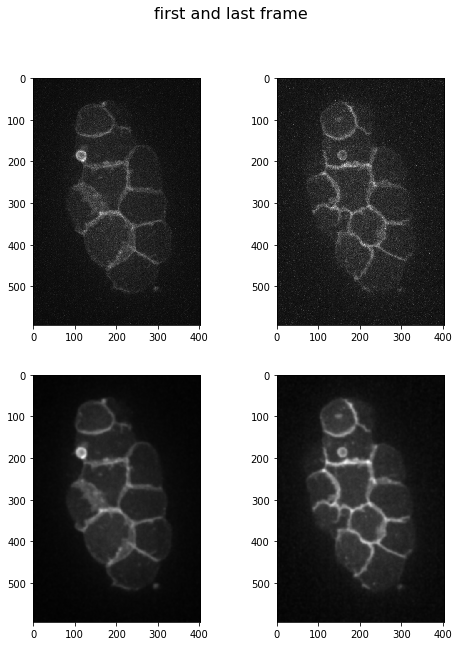

In [270]:
pylab.rcParams['figure.figsize'] = (8, 10)
fig = plt.figure()
fig.suptitle('first and last frame', fontsize=16)
ax = fig.add_subplot(221)
ax.imshow(segchannel[0], plt.get_cmap('gray'))
ax = fig.add_subplot(222)
ax.imshow(segchannel[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(223)
ax.imshow(segchannel_smooth[0], plt.get_cmap('gray'))
ax = fig.add_subplot(224)
ax.imshow(segchannel_smooth[-1], plt.get_cmap('gray'))

# Segmenting a cell

First we create a 'data' object.
We give 3 parameters:
- the channel (images) we want to use for segmenting the cell
- the pixel size in x and y direction (in case the resolution is not isotropic)
- silent: _true_ would mean that no outputs will be printed during segmentation

Then we initialize an _objects_ list (one could add multiple cells to one data object.

In [271]:
data = Data3d( segchannel_smooth, pixelsize=(1.,1.), silent=False )
data.set_seg_params(num_columns=72,K=100,max_delta_k=4)
objects = []

### Adding the cell to the _data_ object

You can name your cell if you wish. We then add the created _cell_ object to the _objects_ list we created above.

In [272]:
cell = data.init_object("name your cell")
objects.append(cell)

So far we did not say where this cell is located in the image. Hence, we add the object at a specific location, here at frame zero, at location (seed point) x=170, y=250. With _segment_it=True_ the object will be segmented right away.

The second line takes the object, the cell, we just seeded at frame 0 and tracks it on all given _target_frames_. We just give a list of all frame ids from 1 to the number of images. The parameter _recenter_iterations_ should usually be at least 1. This is the number of times the segmentation tries to update the given seed point. Values >1 will take more time but might enhance the accuracy of tracking the object.

In [273]:
data.add_object_at( cell, min_rs, max_rs, frame=0, seed=(170,250), segment_it=True )
data.track(cell, seed_frame=0, target_frames=range(1,len(data.images)), recenter_iterations=1)

Added appearance for "name your cell" in frame 0 with seed coordinates [ 170.  250.]
      Optimum energy:  0.0207501794527
      Nodes in/out:  2999 4201
      Area:  9776.0
Added appearance for "name your cell" in frame 1 with seed coordinates [ 170.  250.]
      Optimum energy:  0.0203234779986
      Nodes in/out:  3051 4149
      Area:  9915.0
    Updated center to [171 255]
Added appearance for "name your cell" in frame 2 with seed coordinates [ 171.  255.]
      Optimum energy:  0.0195110703637
      Nodes in/out:  3146 4054
      Area:  10132.5
    Updated center to [172 257]
Added appearance for "name your cell" in frame 3 with seed coordinates [ 172.  257.]
      Optimum energy:  0.0190742892947
      Nodes in/out:  3184 4016
      Area:  10271.0
    Updated center to [173 259]
Added appearance for "name your cell" in frame 4 with seed coordinates [ 173.  259.]
      Optimum energy:  0.0196321674022
      Nodes in/out:  3168 4032
      Area:  10172.0
    Updated center to [174

      Optimum energy:  0.0113801791526
      Nodes in/out:  2800 4400
      Area:  8805.0
    Updated center to [178 260]
Added appearance for "name your cell" in frame 41 with seed coordinates [ 178.  260.]
      Optimum energy:  0.0116456925317
      Nodes in/out:  2762 4438
      Area:  8654.0
    Updated center to [178 260]
Added appearance for "name your cell" in frame 42 with seed coordinates [ 178.  260.]
      Optimum energy:  0.0122346943821
      Nodes in/out:  2744 4456
      Area:  8618.5
    Updated center to [179 260]
Added appearance for "name your cell" in frame 43 with seed coordinates [ 179.  260.]
      Optimum energy:  0.0124089267225
      Nodes in/out:  2865 4335
      Area:  9026.5
    Updated center to [179 260]
Added appearance for "name your cell" in frame 44 with seed coordinates [ 179.  260.]
      Optimum energy:  0.0120933773601
      Nodes in/out:  2802 4398
      Area:  8834.0
    Updated center to [180 261]
Added appearance for "name your cell" in frame

The next command is optional. Without it you will have a segmented cell at every time point you indicated above. **The visualization routine in the next Section will allow you to compare the results of the above and the below segmentation.**

So why another optional line? If you are interested in having a smoothly changing cell outline over time, the line below will do just that. Technically this is achieved by constraining the segmentation to only be allowed to change a certain amount from one time point to the next. (Note: the found solution is still globally optimal given the constraints we put in!)

In [274]:
data.segment2dt( cell, max_radial_delta=2 )

Results for frame 0:
      Optimum energy:  0.726059424324
      Area:  10097.5
Results for frame 1:
      Optimum energy:  0.726059424324
      Area:  10061.5
Results for frame 2:
      Optimum energy:  0.726059424324
      Area:  10081.0
Results for frame 3:
      Optimum energy:  0.726059424324
      Area:  10167.5
Results for frame 4:
      Optimum energy:  0.726059424324
      Area:  10279.0
Results for frame 5:
      Optimum energy:  0.726059424324
      Area:  10353.0
Results for frame 6:
      Optimum energy:  0.726059424324
      Area:  10281.0
Results for frame 7:
      Optimum energy:  0.726059424324
      Area:  10245.5
Results for frame 8:
      Optimum energy:  0.726059424324
      Area:  10408.5
Results for frame 9:
      Optimum energy:  0.726059424324
      Area:  10520.5
Results for frame 10:
      Optimum energy:  0.726059424324
      Area:  10555.5
Results for frame 11:
      Optimum energy:  0.726059424324
      Area:  10466.0
Results for frame 12:
      Optimum en

# Visualizing the results

The following line creates images that show the outline of the segmented object(s).
**Below we will export these images (they will e.g. be needed for the KymographMaker).**

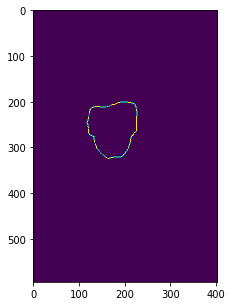

In [275]:
pylab.rcParams['figure.figsize'] = (4, 5)
segimgs = data.create_segmentation_image()
imshow(segimgs[0])

This is just for you visual preasure (and of course to show if everyting worked ok).

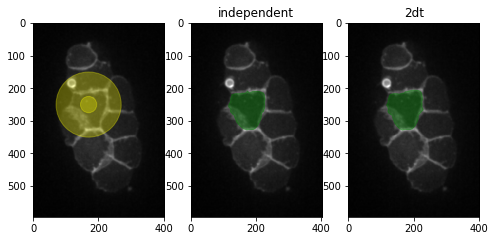

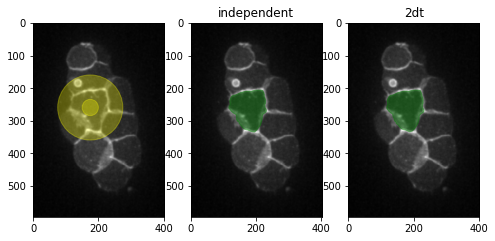

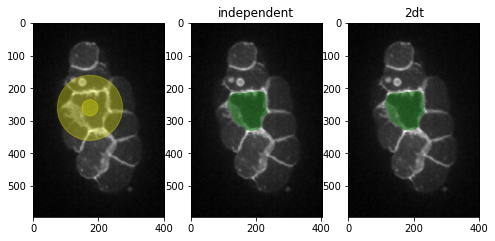

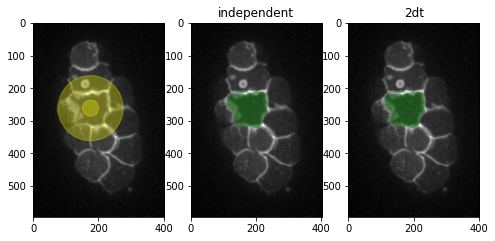

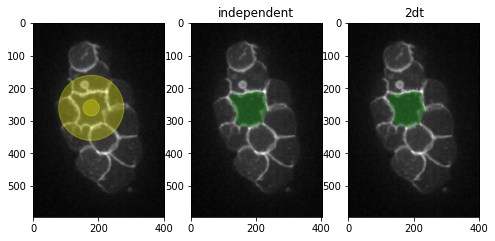

In [276]:
pylab.rcParams['figure.figsize'] = (8, 10)
for frame in range(1,len(data.images),len(data.images)/5):
    fig = plt.figure()
    ax = plt.subplot(131)
    data.plot_minmax( frame, ax )
    ax = plt.subplot(132)
    ax.set_title('independent')
    data.plot_result( frame, ax )    
    ax = plt.subplot(133)
    ax.set_title('2dt')
    data.plot_2dt_result( frame, ax )

# FLOW

### Look at the loaded flow channel images...

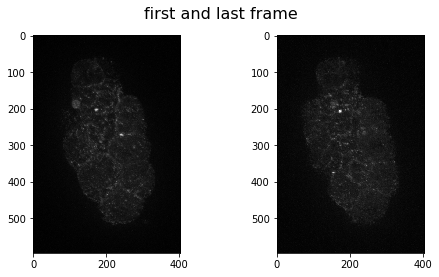

In [277]:
pylab.rcParams['figure.figsize'] = (8, 4)
fig = plt.figure()
fig.suptitle('first and last frame', fontsize=16)
ax = fig.add_subplot(121)
ax.imshow(flowchannel[0], plt.get_cmap('gray'))
ax = fig.add_subplot(122)
ax.imshow(flowchannel[-1], plt.get_cmap('gray'))

Flow computation is also part of the _data_ object we created above. Internally this uses a dense flow procedure implemented in OpenCV. The second cell then renders the image based on the computed flows.

Parameters are:
- the data2d object holding all computation results (including the computed flows)
- the images you want the flow to be computed on
- any second channel that will be used only for the visualization
- a folder into which the visualization frames will be stored
- _inline_: if _False_, a OpenCV window will pop open, otherwise visualizaiton will appear within jupyter (attention: much slower)

In [278]:
data.compute_flow( flowchannel );

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .  ...done!


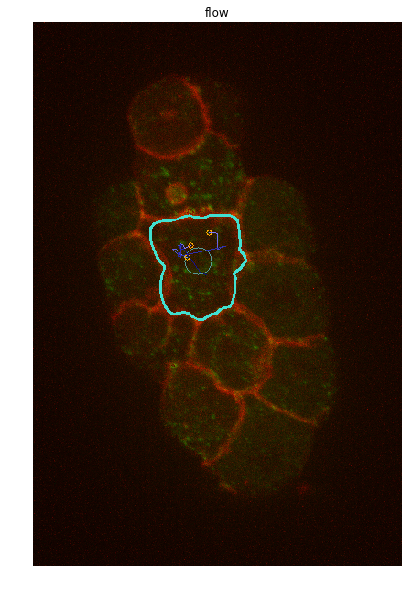

In [283]:
from moviemaker2d import MovieMaker2d
mm = MovieMaker2d( False )
mm.render_flow_movie( data, 
                      segchannel, 
                      flowchannel,
                      folder='/Users/jug/Repositories/GIT/BobSeg/frames3d_tempconsistent_newFeatureTest/', 
                      inline=True )

## Export Data (e.g. for KymographMaker)

In [ ]:
folder = '/Users/jug/Repositories/GIT/BobSeg/export/'

In [ ]:
pylab.rcParams['figure.figsize'] = (6, 4)
fig = plt.figure()
fig.suptitle('flows', fontsize=16)
ax = fig.add_subplot(121)
ax.imshow(np.array(data.flows[1])[:,:,0], plt.get_cmap('gray'))
ax = fig.add_subplot(122)
ax.imshow(np.array(data.flows[1])[:,:,1], plt.get_cmap('gray'))

In [ ]:
imsave(folder+'flow01.tiff', np.swapaxes(np.swapaxes(data.flows,1,3),2,3))
imsave(folder+'stack01.tiff', stack)
imsave(folder+'seg01.tiff', segimgs)